In [ ]:
%reset

In [1]:
cd ~/PYTHON/ECOGpy/

/home/knight/matar/PYTHON/ECOGpy


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import pandas as pd
import os
from scipy import stats
from utils.loadmat import loadmat
from utils.fdr_correct import fdr2
import scipy.io as spio
import numpy as np

In [4]:
base = '/home/knight/matar/MATLAB/DATA/Avgusta/'
savedir = os.path.join(base, 'PCA', 'bins', 'byROI')
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

In [6]:
filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

In [7]:
brainROI = loadmat('/home/knight/matar/MATLAB/DATA/Avgusta/ROIs/brain_ROI.mat')
brainROI = brainROI['brain_ROI']


In [25]:
ROIlist = []
for k in brainROI.keys():
    ROIlist.extend(brainROI[k].keys())
np.unique(ROIlist)

array(['ATL', 'Area_37', 'Broca', 'Depth', 'FMG', 'FrPole', 'IFG', 'IPL',
       'ITG', 'InfTemp', 'MFG', 'MFG_prem', 'MFG_premot', 'MTG',
       'MedOccip', 'MedPFC', 'MedParietal', 'OFC', 'Occip', 'Occip_par',
       'PCC', 'Post_centrl', 'PreSMA', 'Pre_centrl', 'R', 'R_ATL',
       'R_Area_37', 'R_FrPole', 'R_IFG', 'R_IPL', 'R_ITG', 'R_InfTemp',
       'R_MFG', 'R_MFG_prem', 'R_MFG_premot', 'R_MTG', 'R_MedOccip',
       'R_MedParietal', 'R_OFC', 'R_PCC', 'R_Post_centrl', 'R_PreSMA',
       'R_Pre_centrl', 'R_SFG', 'R_SMA', 'R_SPL', 'R_STG', 'R_dACC', 'SFG',
       'SMA', 'SPL', 'STG', 'dACC', 'medPFC', 'preSMA'], 
      dtype='|S13')

In [26]:
PFC = ['Broca','FrPole','IFG','MFG','MFG_premot','OFC','PreSMA','SFG','dACC','preSMA']
motor = ['Pre_centrl','Post_centrl', 'SMA']
sensory = ['STG','MTG', 'Occip', 'MedOccip']

In [60]:
## create data for PFC, motor, sensory
datadir = os.path.join(base, 'Subjs')

PFC_all, motor_all, sensory_all = [pd.DataFrame() for i in range(3)]


for j in df[['subj','task']].drop_duplicates().values:
    subj, task = j

    filename = os.path.join(base, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat(filename)
    data = data_dict['data_zscore']
    active_elecs = data_dict['active_elecs']
    RTs = data_dict['RTs']

    PFC_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(PFC))].elec.values
    motor_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(motor))].elec.values
    sensory_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(sensory))].elec.values
    
    eidx = np.in1d(active_elecs, PFC_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        PFC_all = PFC_all.append(pd.DataFrame(datastack, index = RTs_all))

    eidx = np.in1d(active_elecs, motor_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        motor_all = motor_all.append(pd.DataFrame(datastack, index = RTs_all))

    eidx = np.in1d(active_elecs, sensory_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        sensory_all = sensory_all.append(pd.DataFrame(datastack, index = RTs_all))


In [61]:
#format data
PFC_all = PFC_all.sort_index(inplace=False)
PFC_all = PFC_all.fillna(0)

motor_all = motor_all.sort_index(inplace=False)
motor_all = motor_all.fillna(0)

sensory_all = sensory_all.sort_index(inplace=False)
sensory_all = sensory_all.fillna(0)

allRTs = PFC_all.index.values
allRTs = np.array([x for x in allRTs])

allRTs_resp = motor_all.index.values
allRTs_resp = np.array([x for x in allRTs_resp])

allRTs_sensory = sensory_all.index.values
allRTs_sensory = np.array([x for x in allRTs_sensory])

PFC_all = np.array(PFC_all)
motor_all = np.array(motor_all)
sensory_all = np.array(sensory_all)

In [62]:
#calculate bins for response and duration
bins = np.arange(allRTs.min(), allRTs.max(), 50)
start_i = 0 #pfc
start_i_resp = 0 #motor
new_b = 0
tmp = pd.DataFrame()
for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue   
    
    
    #tmp = tmp.append(pd.DataFrame([start_i, end_i+1, allRTs[start_i : end_i+1][0], allRTs[start_i:end_i+1][-1],allRTs[start_i:end_i+1].mean()]).transpose())
    tmp = tmp.append(pd.DataFrame([start_i, end_i+1, start_i_resp, end_i_resp+1]).transpose())

tmp.columns = ['start_i','end_i+1','start_i_resp','end_i_resp+1']

filename = os.path.join(savedir, 'windows_idx.csv')
tmp.to_csv(filename)

In [63]:
#calculate bins for sensory and duration
bins = np.arange(np.max([allRTs.min(), allRTs_sensory.min()]), allRTs.max(), 50) #bc shortest sensory RT > duration RT
start_i = 0 #pfc
start_i_stim = 0 #sensory
new_b = 0
tmp = pd.DataFrame()
for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_stim = end_i_stim+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_stim = np.where(allRTs_sensory <= (b))[-1][-1] #define stim bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue   
    
    tmp = tmp.append(pd.DataFrame([start_i, end_i+1, start_i_stim, end_i_stim+1]).transpose())

tmp.columns = ['start_i','end_i+1','start_i_stim','end_i_stim+1']

filename = os.path.join(savedir, 'windows_idx_stim.csv')
tmp.to_csv(filename)

In [66]:
savedir = os.path.join(base, 'PCA', 'bins', 'byROI')
savedir = os.path.join(savedir, 'sensory')
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI/sensory'

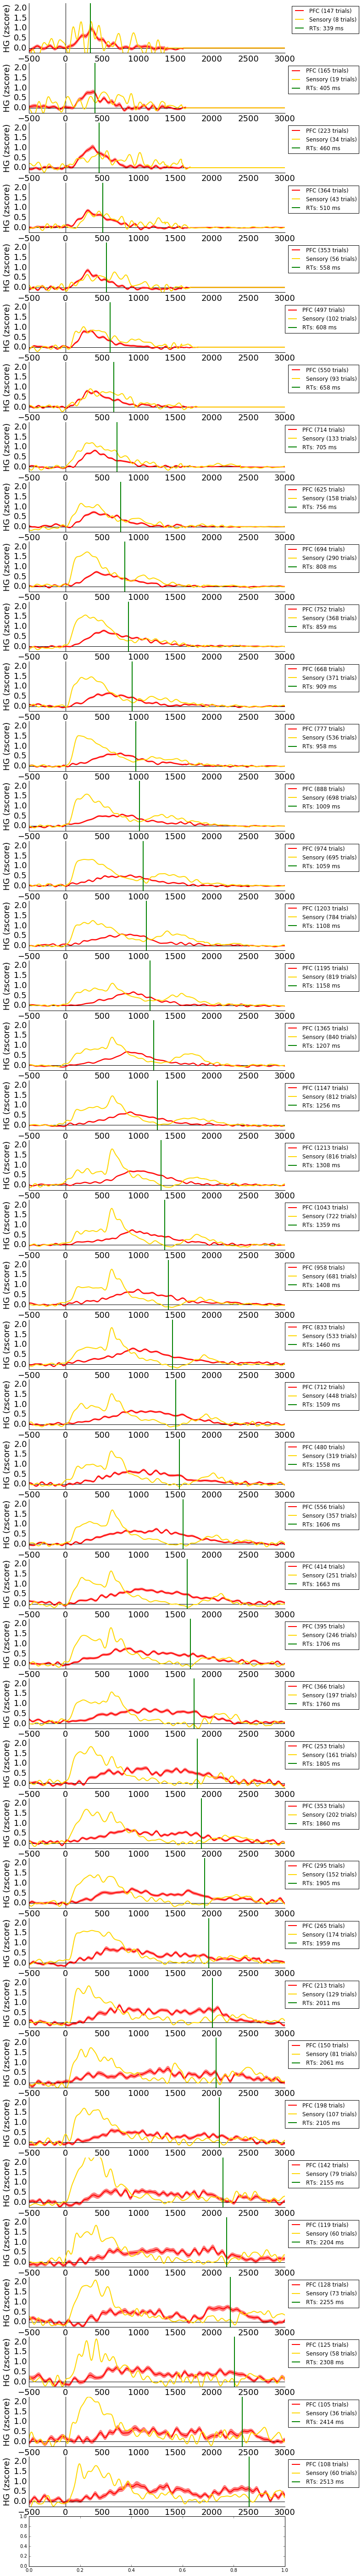

In [69]:
f, ax = plt.subplots(43, 1, figsize = (10,100))
cnt = 0
for i in tmp.iterrows():
    start_i = i[1].start_i
    end_i = i[1]['end_i+1']
#     start_i_resp = i[1].start_i_resp
#     end_i_resp = i[1]['end_i_resp+1']
    start_i_stim = i[1].start_i_stim
    end_i_stim = i[1]['end_i_stim+1']
    
    data = PFC_all[start_i:end_i,:]
    data_resp = motor_all[start_i_resp:end_i_resp,:]
    data_stim = sensory_all[start_i_stim:end_i_stim,:]
    
    #save data
    rt_label = allRTs[start_i:end_i].mean()
    #filename = os.path.join(savedir, 'trace_data', 'trace_data_%ims.mat' %(rt_label))
    #spio.savemat(filename, {'data_PFC':data, 'data_motor':data_resp})
    #spio.savemat(filename, {'data_PFC':data.mean(axis = 0), 'data_motor':data_resp.mean(axis = 0)})
    filename = os.path.join(savedir, 'trace_data', 'trace_data_%ims_mean.mat' %(rt_label))
    spio.savemat(filename, {'data_PFC':data.mean(axis = 0), 'data_sensory':data_stim.mean(axis = 0)})
    
    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'PFC (%i trials)' %(len(allRTs[start_i:end_i])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'r', label = None)

#     ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, label = 'Motor (%i trials)' %(len(allRTs_resp[start_i_resp:end_i_resp])))
#     sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
#     ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].plot(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0), color = 'gold', lw = 2, label = 'Sensory (%i trials)' %(len(allRTs_sensory[start_i_stim:end_i_stim])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i].mean())) 

    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 18)
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 3000])

    ax[cnt].xaxis.set_tick_params(labelsize = 18)
    ax[cnt].yaxis.set_tick_params(labelsize = 18)
    ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'off', right = 'off', left = 'off')

    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1))            

    cnt += 1

ax[cnt-1].set_xlabel('Time (ms)', fontsize = 18)  

filename = os.path.join(savedir, 'binned_RTs_PFC_sensory_allbins.png')

f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')

In [ ]:
savedir
